# **AntiMicrobial Resistance Prediction from SNPs**

This notebook contains the end-to-end Custom 1D CNN implementation of **AMR Prediction from SNPs** project for the Gentamicin (GEN) antibiotic. Feel free to use/customise the model architecture.

#**Setup & Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score, cohen_kappa_score, matthews_corrcoef
import seaborn as sns

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "GEN"

# Model Hyperparameters for 1D CNN
VOCAB_SIZE = 5      # N:0, A:1, G:2, C:3, T:4
EMBEDDING_DIM = 64  # Dimension for the embedding layer (can be tuned)
MAX_SEQ_LEN = None  # Will be determined from data
DROPOUT_RATE = 0.45  # Regularization for Dense layers
CONV_DROPOUT_RATE = 0.15 # Regularization for Conv layers

# Training Hyperparameters
EPOCHS = 150 # Can be tuned
BATCH_SIZE = 32 # Can be tuned
LEARNING_RATE = 1e-3 # Can be tuned
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.2

# Seed for reproducibility (Can be shuffled)
tf.random.set_seed(42)
np.random.seed(42)

# Checking for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")


Using GPU: /physical_device:GPU:0


# **Initial Preprocessing**

In [ ]:
print("\n--- Loading and Preprocessing Data for 1D CNN ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure '{SNP_MATRIX_FILE}' and '{PHENOTYPES_FILE}' are in the same directory.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

# Setting 'prename' as index for easy merging
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

# Merging SNP data with phenotype data
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

# Handling potential NaN values
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
# Filling NaNs in SNP features with 0 (assuming this corresponds to 'N' or unknown)
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separating features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

snp_position_names = features_df.columns.tolist()

# --- Integer Encoding (Data is already in this format 0-4) ---
X_integer_encoded = features_df.values.astype(np.int32)

MAX_SEQ_LEN = X_integer_encoded.shape[1] # This is the number of SNP positions
print(f"Sequence length (number of SNPs): {MAX_SEQ_LEN}")
print(f"Labels shape: {labels.shape}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")
if np.any(X_integer_encoded >= VOCAB_SIZE) or np.any(X_integer_encoded < 0):
    print("WARNING: SNP values out of expected range [0, VOCAB_SIZE-1]. Check encoding.")


--- Loading and Preprocessing Data for 1D CNN ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Sequence length (number of SNPs): 60936
Labels shape: (809,)
Class distribution: Resistant (1): 188, Susceptible (0): 621


# **Data Splitting**

In [ ]:
print("\n--- Splitting Data ---")

X_train, X_test, y_train, y_test = train_test_split(
    X_integer_encoded, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}, Sequence Length: {X_train.shape[1]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647, Sequence Length: 60936
Test samples: 162


# **1D CNN Model Definition**

In [ ]:
print("\n--- Defining the 1D CNN Model (Extended to 6 Convolutional Blocks) ---")

def build_cnn1d_model_extended(maxlen, vocab_size, embed_dim, num_classes_binary, conv_dropout_rate, dense_dropout_rate):
    inputs = keras.Input(shape=(maxlen,), name="snp_input_sequence")

    # Embedding layer
    x = layers.Embedding(input_dim=vocab_size,
                         output_dim=embed_dim,
                         input_length=maxlen,
                         name="embedding_layer")(inputs)
    # x = layers.SpatialDropout1D(0.15)(x) # Optional: Dropout after embedding, slightly increased (I don't recommend it!)

    # Convolutional blocks - Doubled
    # Block 1
    x = layers.Conv1D(filters=128, kernel_size=7, padding="same",
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_1")(x)
    x = layers.BatchNormalization(name="batchnorm_1")(x)
    x = layers.Activation("relu", name="relu_1")(x)
    x = layers.MaxPooling1D(pool_size=2, name="maxpool_1")(x) # Adjusted pool_size slightly
    # x = layers.Dropout(conv_dropout_rate, name="conv_dropout_1")(x)    ## Worked well after commenting out this layer

    # Block 2
    x = layers.Conv1D(filters=128, kernel_size=7, padding="same", # Repeating similar block
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_2")(x)
    x = layers.BatchNormalization(name="batchnorm_2")(x)
    x = layers.Activation("relu", name="relu_2")(x)
    x = layers.MaxPooling1D(pool_size=2, name="maxpool_2")(x) # Adjusted pool_size
    # x = layers.Dropout(conv_dropout_rate, name="conv_dropout_2")(x)    ## Worked well after commenting out this layer

    # Block 3
    x = layers.Conv1D(filters=64, kernel_size=5, padding="same",
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_3")(x)
    x = layers.BatchNormalization(name="batchnorm_3")(x)
    x = layers.Activation("relu", name="relu_3")(x)
    x = layers.MaxPooling1D(pool_size=2, name="maxpool_3")(x) # Adjusted pool_size
    # x = layers.Dropout(conv_dropout_rate, name="conv_dropout_3")(x)    ## Worked well after commenting out this layer

    # Block 4
    x = layers.Conv1D(filters=64, kernel_size=5, padding="same", # Repeating similar block
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_4")(x)
    x = layers.BatchNormalization(name="batchnorm_4")(x)
    x = layers.Activation("relu", name="relu_4")(x)
    x = layers.MaxPooling1D(pool_size=2, name="maxpool_4")(x) # Adjusted pool_size
    # x = layers.Dropout(conv_dropout_rate, name="conv_dropout_4")(x)    ## Worked well after commenting out this layer

    # Block 5
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same",
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_5")(x)
    x = layers.BatchNormalization(name="batchnorm_5")(x)
    x = layers.Activation("relu", name="relu_5")(x)
    # No MaxPooling after the last few conv blocks sometimes helps retain info before GlobalPooling
    x = layers.Dropout(conv_dropout_rate, name="conv_dropout_5")(x)


    # Block 6
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same",
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_6")(x)
    x = layers.BatchNormalization(name="batchnorm_6")(x)
    x = layers.Activation("relu", name="relu_6")(x)
    # No MaxPooling here either
    x = layers.Dropout(conv_dropout_rate, name="conv_dropout_6")(x)


    # Flatten or Pool for Dense layers
    x = layers.GlobalMaxPooling1D(name="global_max_pooling")(x)         ## GlobalMaxPooling worked better than flattening and GlobalAvgPooling
    # x = layers.GlobalAveragePooling1D(name="global_avg_pooling")(x)
    # x = layers.Flatten()(x) # Alternative

    # Dense classification head
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="dense_1")(x)
    x = layers.Dropout(dense_dropout_rate, name="dense_dropout_1")(x)
    # x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="dense_2")(x)        ## Worked well after removing this dense layer
    # x = layers.Dropout(dense_dropout_rate, name="dense_dropout_2")(x)     ## Worked well after commenting out this layer

    outputs = layers.Dense(num_classes_binary, activation='sigmoid', name="output_layer")(x)

    model = keras.Model(inputs, outputs, name="Extended_CNN1D_AMR_Model")
    return model

# MAX_SEQ_LEN, VOCAB_SIZE, EMBEDDING_DIM, CONV_DROPOUT_RATE, DROPOUT_RATE are defined in Cell 1
cnn_model = build_cnn1d_model_extended(MAX_SEQ_LEN, VOCAB_SIZE, EMBEDDING_DIM, 1, CONV_DROPOUT_RATE, DROPOUT_RATE)

cnn_model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=LEARNING_RATE), # Or Adam
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)

cnn_model.summary()


--- Defining the 1D CNN Model (Extended to 6 Convolutional Blocks) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Extended_CNN1D_AMR_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ snp_input_sequence (InputLayer) │ (None, 60936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 60936, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60936, 128)     │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 60936, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 60936, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 30468, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30468, 128)     │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 30468, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (Activation)             │ (None, 30468, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling1D)        │ (None, 15234, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15234, 64)      │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 15234, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (Activation)             │ (None, 15234, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling1D)        │ (None, 7617, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 7617, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 7617, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (Activation)             │ (None, 7617, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_4 (MaxPooling1D)        │ (None, 3808, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3808, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 3808, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_5 (Activation)             │ (None, 3808, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dropout_5 (Dropout)        │ (None, 3808, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 249,601 (975.00 KB)

 Trainable params: 248,705 (971.50 KB)

 Non-trainable params: 896 (3.50 KB)

# **Model Training**


--- Starting 1D CNN Model Training ---
Class weights for CNN: {0: np.float64(0.6513687600644122), 1: np.float64(2.151595744680851)}
Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5044 - auc: 0.5704 - loss: 1.7866 - precision: 0.2821 - recall: 0.6587 - val_accuracy: 0.2346 - val_auc: 0.5000 - val_loss: 1.1993 - val_precision: 0.2346 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.5082 - auc: 0.5191 - loss: 1.4915 - precision: 0.2456 - recall: 0.4916 - val_accuracy: 0.2346 - val_auc: 0.5719 - val_loss: 1.2371 - val_precision: 0.2346 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.5483 - auc: 0.5444 - loss: 1.3670 - precision: 0.2588 - recall: 0.4539 - val_accuracy: 0.2346 - val_auc: 0.5814 - val_loss: 1.2560 - val_precision: 0.2346 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.6

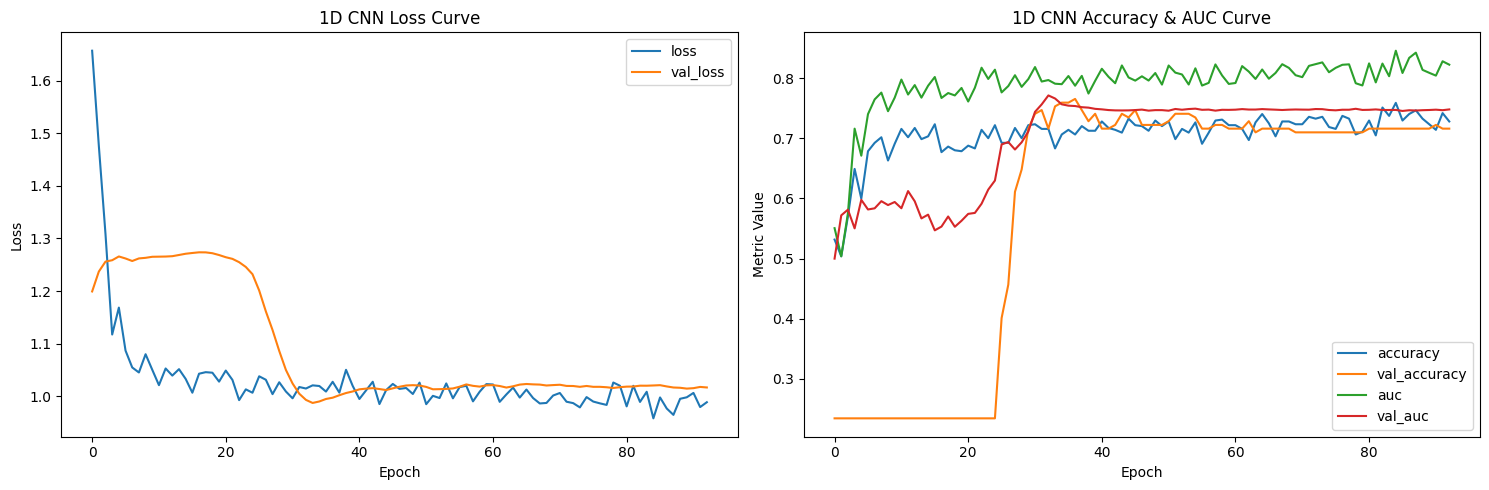

In [ ]:
print("\n--- Starting 1D CNN Model Training ---")

# Calculating class weights for imbalanced dataset
neg_total, pos_total = np.bincount(labels)
total_samples = neg_total + pos_total
weight_for_0_cnn = (1 / neg_total) * (total_samples / 2.0) if neg_total > 0 else 0
weight_for_1_cnn = (1 / pos_total) * (total_samples / 2.0) if pos_total > 0 else 0
class_weight_cnn = {0: weight_for_0_cnn, 1: weight_for_1_cnn}

print(f"Class weights for CNN: {class_weight_cnn}")

callbacks_list_cnn = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_cnn1d_model.keras",
        save_best_only=True,
        monitor="val_auc", # Monitoring validation AUC for best model
        mode="max"
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=60,         # Stop if val_auc doesn't improve for 60 epochs (a bit too much but it works!)
        mode="max",
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        min_lr=5e-6        # Can be tuned
    )
]

history_cnn = cnn_model.fit(
    X_train, y_train, # X_train should be integer encoded
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), # X_val should be integer encoded
    callbacks=callbacks_list_cnn,
    class_weight=class_weight_cnn
)

print("--- 1D CNN Training Finished ---")

# Plot training history
history_df_cnn = pd.DataFrame(history_cnn.history)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
history_df_cnn[['loss', 'val_loss']].plot(ax=axes[0])
#axes[0].set_title('1D CNN Loss Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
history_df_cnn[['accuracy', 'val_accuracy', 'auc', 'val_auc']].plot(ax=axes[1])
#axes[1].set_title('1D CNN Accuracy & AUC Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric Value')
plt.tight_layout()
plt.show()

# **Model Evaluation**


--- Evaluating 1D CNN Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.7407
AUC Score: 0.7691
Cohen's Kappa: 0.3155
Matthews Correlation Coefficient (MCC): 0.3170

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.8475    0.8065    0.8264       124
  Resistant (1)     0.4545    0.5263    0.4878        38

       accuracy                         0.7407       162
      macro avg     0.6510    0.6664    0.6571       162
   weighted avg     0.7553    0.7407    0.7470       162


Confusion Matrix:


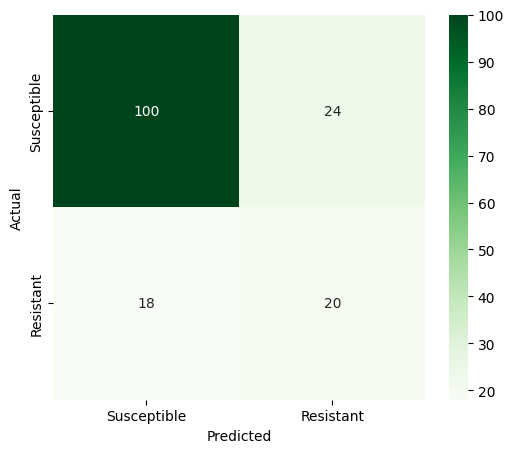

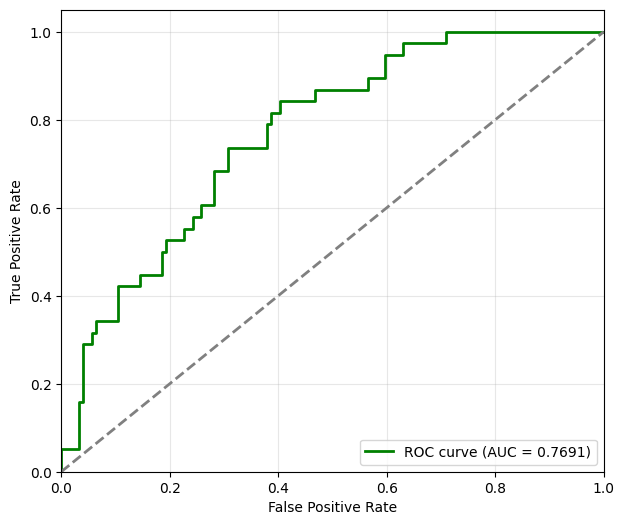

In [ ]:
print("\n--- Evaluating 1D CNN Model on Test Set ---")

# Loading the best CNN model saved by the callback
best_cnn_model = keras.models.load_model("best_cnn1d_model.keras")

# --- Predictions on the Test Set ---
# Getting probabilities for AUC and ROC curve
y_pred_probs_cnn = best_cnn_model.predict(X_test, verbose=0).ravel()
# Getting class predictions (using 0.505 threshold) for other metrics
y_pred_classes_cnn = (y_pred_probs_cnn > 0.505).astype(int)

# --- Calculating All Metrics ---
accuracy_cnn = accuracy_score(y_test, y_pred_classes_cnn)
auc_cnn = roc_auc_score(y_test, y_pred_probs_cnn)
kappa_cnn = cohen_kappa_score(y_test, y_pred_classes_cnn)
mcc_cnn = matthews_corrcoef(y_test, y_pred_classes_cnn)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_cnn:.4f}")
print(f"AUC Score: {auc_cnn:.4f}")
print(f"Cohen's Kappa: {kappa_cnn:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_cnn:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
report_cnn = classification_report(
    y_test,
    y_pred_classes_cnn,
    target_names=["Susceptible (0)", "Resistant (1)"],
    digits=4
)
print(report_cnn)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_cnn = confusion_matrix(y_test, y_pred_classes_cnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', # Changed color map for variety
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (1D CNN)')
plt.show()

# --- ROC Curve ---
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_probs_cnn)
plt.figure(figsize=(7, 6))
plt.plot(fpr_cnn, tpr_cnn, color='green', lw=2, label=f'ROC curve (AUC = {auc_cnn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (1D CNN)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()